In [2]:
!pip install -q git+https://github.com/Deci-AI/super-gradients.git@stable

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install imutils
!pip install pytube --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.0 MB/s eta 0:00:00


In [4]:
!pip install supervision
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00


In [5]:
import torch
import os
from super_gradients.training import models

[2024-08-14 10:21:11] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-08-14 10:21:25] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-08-14 10:21:28] INFO - env_sanity_check.py - Library check is not supported when super_gradients installed through "git+https://github.com/..." command


In [6]:
import cv2
import supervision as sv

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# MODEL_ARCH = 'yolo_nas_s'

# model = models.get(MODEL_ARCH, pretrained_weights="coco").to(DEVICE)

In [8]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [9]:
from roboflow import Roboflow
rf = Roboflow(api_key="API_key")
project = rf.workspace("atathamuscoinsdataset").project("u.s.-coins-dataset-a.tatham")
dataset = project.version(5).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to U.S.-Coins-Dataset---A.Tatham-5 in yolov5pytorch::   0%|          | 0/3306 [00:00<?, ?it/s]

Extracting Dataset Version Zip to U.S.-Coins-Dataset---A.Tatham-5 in yolov5pytorch:: 100%|██████████| 3306/3306 [00:02<00:00, 1297.33it/s]


In [10]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [11]:
dataset_params = {
    'data_dir':'/content/U.S.-Coins-Dataset---A.Tatham-5',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Dime', 'Nickel', 'Penny', 'Quarter']
}

In [12]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

clear_output()


In [13]:
train_data.dataset.transforms

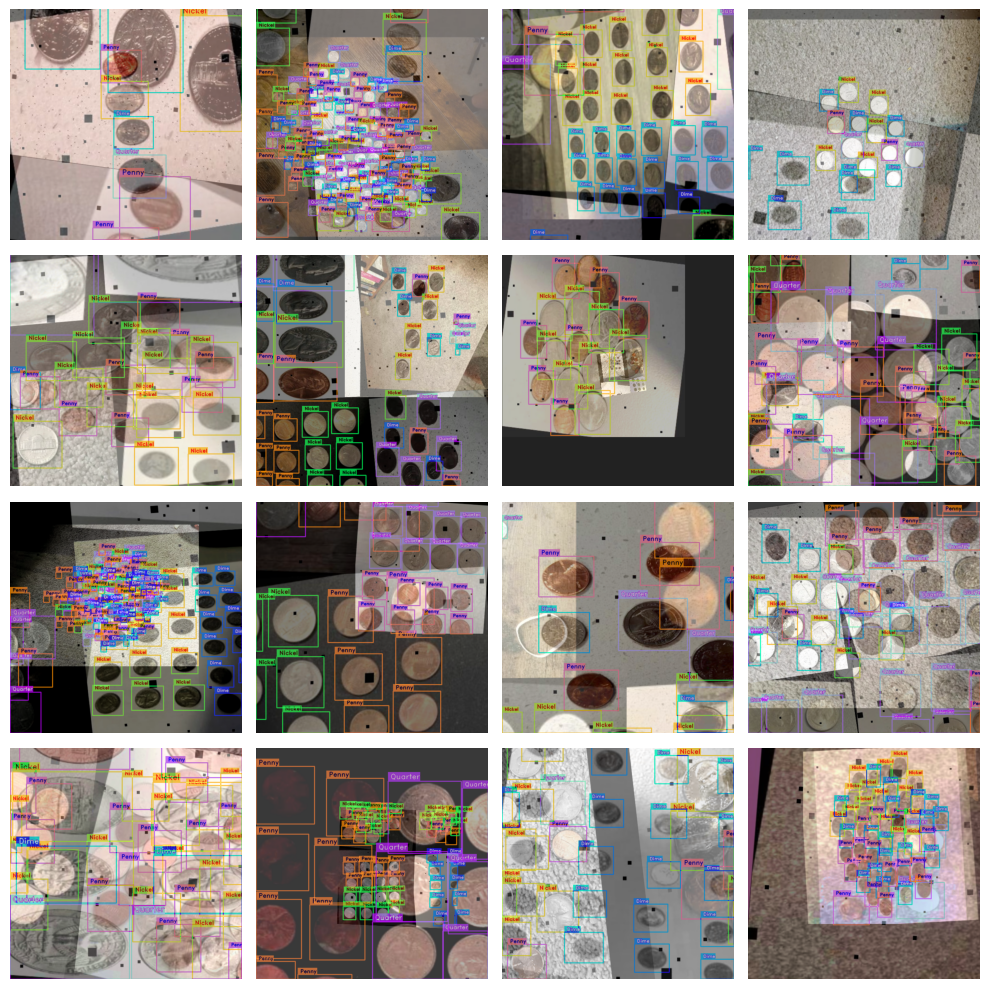

In [14]:
train_data.dataset.plot()

In [16]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-08-14 10:23:03] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-08-14 10:23:03] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:00<00:00, 308MB/s]
[2024-08-14 10:23:05] INFO - checkpoi

In [17]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 2,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}


In [18]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-08-14 10:23:12] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240814_102312_276736`
[2024-08-14 10:23:12] INFO - sg_trainer.py - Checkpoints directory: checkpoints/my_first_yolonas_run/RUN_20240814_102312_276736
[2024-08-14 10:23:12] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


The console stream is now moved to checkpoints/my_first_yolonas_run/RUN_20240814_102312_276736/console_Aug14_10_23_12.txt


[2024-08-14 10:23:15] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            1395       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         174        (len(train_loader))
    - Gradient updates per epoch:   174        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (19.02M parameters, 19.02M optimized)
    - Learning Rates and Weight Decays:
      - default: (19.02M parameters). LR: 0.0005 (19.02M parameters) WD: 0.0, (42.14K parameters), WD: 0.0001, (18.98M parameters)

[2024-08-14 10:23:15] INFO - sg_trainer.py - Started training for 2

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.6181
│   ├── Ppyoloeloss/loss_iou = 0.6003
│   ├── Ppyoloeloss/loss_dfl = 0.5991
│   └── Ppyoloeloss/loss = 3.8175
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.833
    ├── Ppyoloeloss/loss_iou = 0.475
    ├── Ppyoloeloss/loss_dfl = 0.462
    ├── Ppyoloeloss/loss = 3.77
    ├── Precision@0.50 = 0.0047
    ├── Recall@0.50 = 0.0007
    ├── Map@0.50 = 0.0011
    ├── F1@0.50 = 0.0012
    └── Best_score_threshold = 0.03



Validating epoch 1: 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]
[2024-08-14 10:28:34] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/RUN_20240814_102312_276736/ckpt_best.pth
[2024-08-14 10:28:34] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.32144537568092346


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0943
│   │   ├── Epoch N-1      = 2.6181 (↘ -1.5237)
│   │   └── Best until now = 2.6181 (↘ -1.5237)
│   ├── Ppyoloeloss/loss_iou = 0.4551
│   │   ├── Epoch N-1      = 0.6003 (↘ -0.1452)
│   │   └── Best until now = 0.6003 (↘ -0.1452)
│   ├── Ppyoloeloss/loss_dfl = 0.4103
│   │   ├── Epoch N-1      = 0.5991 (↘ -0.1888)
│   │   └── Best until now = 0.5991 (↘ -0.1888)
│   └── Ppyoloeloss/loss = 1.9597
│       ├── Epoch N-1      = 3.8175 (↘ -1.8578)
│       └── Best until now = 3.8175 (↘ -1.8578)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9971
    │   ├── Epoch N-1      = 2.833  (↘ -1.8359)
    │   └── Best until now = 2.833  (↘ -1.8359)
    ├── Ppyoloeloss/loss_iou = 0.4089
    │   ├── Epoch N-1      = 0.475  (↘ -0.0661)
    │   └── Best until now = 0.475  (↘ -0.0661)
    ├── Ppyoloeloss/loss_dfl = 0.3446
    │   ├── Epoch N-1      = 0.462  (↘ -0.1174)
    │   └── Best until now = 0.462  (↘ -0.1174)
    ├── Ppyoloeloss/lo

[2024-08-14 10:28:35] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 17/17 [00:07<00:00,  3.14it/s]

In [19]:
checkpoints_base_dir = "/content/checkpoints/my_first_yolonas_run"
checkpoint_dirs = [d for d in os.listdir(checkpoints_base_dir) if os.path.isdir(os.path.join(checkpoints_base_dir, d))]
checkpoint_dirs.sort()
latest_checkpoint_dir = checkpoint_dirs[-1]

latest_checkpoint_path = os.path.join(checkpoints_base_dir, latest_checkpoint_dir, 'ckpt_best.pth')


In [20]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path=latest_checkpoint_path)

Validating epoch 2: 100%|██████████| 17/17 [00:07<00:00,  2.17it/s]
[2024-08-14 10:28:43] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [21]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))


[2024-08-14 10:28:44] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/my_first_yolonas_run/RUN_20240814_102312_276736/ckpt_best.pth EMA checkpoint.
Testing:  67%|██████▋   | 2/3 [00:01<00:00,  1.78it/s]

{'PPYoloELoss/loss_cls': 0.9807959,
 'PPYoloELoss/loss_iou': 0.34659448,
 'PPYoloELoss/loss_dfl': 0.37464166,
 'PPYoloELoss/loss': 1.702032,
 'Precision@0.50': 0.19152401387691498,
 'Recall@0.50': 0.9817810654640198,
 'mAP@0.50': 0.5665332078933716,
 'F1@0.50': 0.3061690926551819,
 'Best_score_threshold': 0.3199999928474426}

# Eval

In [29]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [30]:
!git clone https://github.com/Jozefov/mAP.git

Cloning into 'mAP'...
remote: Enumerating objects: 820, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (27/27), done.


In [31]:
!pip install pybboxes

remote: Total 820 (delta 129), reused 119 (delta 118), pack-reused 675 (from 1)
Receiving objects: 100% (820/820), 5.18 MiB | 4.41 MiB/s, done.
Resolving deltas: 100% (307/307), done.


In [25]:
import pybboxes as pbx

In [22]:
# Path to your COCO validation images
coco_val_directory = '/content/U.S.-Coins-Dataset---A.Tatham-5/test/images'

# List all jpg images in the validation directory
# Also important as on this will be based your sortings of prediction
image_paths = [os.path.join(coco_val_directory, img) for img in os.listdir(coco_val_directory) if img.endswith('.jpg')]


In [38]:
from PIL import Image

In [39]:
model_predictions = best_model.to(device).predict(image_paths, conf=0.20)

UnidentifiedImageError: cannot identify image file '/content/U.S.-Coins-Dataset---A.Tatham-5/test/images/IMG_8483_jpg.rf.c3dfe806d5c64f7ead5d7fd3db1f388f.jpg'

In [33]:
image_paths[1:]

['/content/U.S.-Coins-Dataset---A.Tatham-5/test/images/20220628_210342_jpg.rf.5898b6aa0b9b29832354e3f0ff90d729.jpg',
 '/content/U.S.-Coins-Dataset---A.Tatham-5/test/images/S1_jpg.rf.213429a5893289043aeed8a8fde380e5.jpg',
 '/content/U.S.-Coins-Dataset---A.Tatham-5/test/images/IMG_8499_jpg.rf.3204c94012ac8b88b34559e7ad6a94f1.jpg',
 '/content/U.S.-Coins-Dataset---A.Tatham-5/test/images/IMG_8487_jpg.rf.c9982962add08516d15b75698e9c13e1.jpg',
 '/content/U.S.-Coins-Dataset---A.Tatham-5/test/images/IMG_8476_jpg.rf.682be7535707b538c4154a63bf8c2e14.jpg',
 '/content/U.S.-Coins-Dataset---A.Tatham-5/test/images/C_White_Clean_jpg.rf.745f673843560ae5e9c29d0a62931a19.jpg',
 '/content/U.S.-Coins-Dataset---A.Tatham-5/test/images/S15_jpg.rf.8918bc44131fbf818191f0ff42496664.jpg',
 '/content/U.S.-Coins-Dataset---A.Tatham-5/test/images/fe0f4921-20220628_230244_jpg.rf.1a3a5a9c87d2d6cc8c528077a1e399a9.jpg',
 '/content/U.S.-Coins-Dataset---A.Tatham-5/test/images/S20_jpg.rf.40e95a1a98f920bc3c1ab3d10d63cca6.jpg'

In [ ]:
model_predictions[0]

ImageDetectionPrediction(image=array([[[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [5, 1, 2],
        [5, 0, 4],
        [5, 0, 4]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [5, 1, 2],
        [5, 0, 4],
        [5, 0, 4]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [5, 1, 2],
        [5, 0, 4],
        [5, 0, 4]],

       ...,

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [5, 1, 2],
        [5, 1, 2],
        [5, 1, 2]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [5, 0, 4],
        [5, 0, 4],
        [5, 0, 4]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [5, 0, 4],
        [5, 0, 4],
        [5, 0, 4]]], dtype=uint8), prediction=DetectionPrediction(bboxes_xyxy=array([[ 766.96875,  932.34375,  938.25   , 1074.9375 ],
       [ 755.5781 ,  660.2344 ,  929.8125 ,  798.1875 ]], dtype=floa

In [35]:
import os
import cv2
import pybboxes as pbx

def generate_ground_truth(image_dir,label_dir, output_dir, class_mapping, input_format_truth='yolo', input_format_pred='voc'):
    """
    Converts YOLOv5 annotations and model predictions to the required format for mAP evaluation.

    Args:
        image_dir (str): Directory containing image files (e.g., JPG).
        label_dir (str): Directory containing YOLOv5 TXT label files (class_id center_x center_y width height).
                         The label files should have the same base name as the corresponding image
                         files, with the extension .txt.
        output_dir (str): Directory to save the ground-truth and detection-results files.
                          The ground-truth files will be saved in `output_dir/ground-truth/` and
                          the detection-results files will be saved in `output_dir/detection-results/`.
        class_mapping (dict): A dictionary mapping class IDs (int) to class names (str).
                              For example: {0: 'Dime', 1: 'Nickel', 2: 'Penny', 3: 'Quarter'}.
        input_format_truth (str, optional): The format of the input ground-truth bounding boxes.
                                            Default is 'yolo', assuming YOLOv5 format.
        input_format_pred (str, optional): The format of the input prediction bounding boxes.
                                           Default is 'voc', assuming VOC format.

    Returns:
        None: The function writes the converted ground-truth and detection-results files to the specified
              `output_dir` in a format compatible with the Cartucho/mAP evaluation tool.
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    gt_dir = os.path.join(output_dir, 'ground-truth')
    dr_dir = os.path.join(output_dir, 'detection-results')
    os.makedirs(gt_dir, exist_ok=True)
    os.makedirs(dr_dir, exist_ok=True)


    for image_name in os.listdir(image_dir):
        if image_name.endswith('.jpg'):
            # Extract the base name without extension to find the corresponding label file
            base_name = os.path.splitext(image_name)[0]
            label_file = os.path.join(label_dir, f"{base_name}.txt")

            if not os.path.exists(label_file):
                print(f"Warning: Label file not found for image: {image_name}")
                continue

            # Load the image to get its size
            image_path = os.path.join(image_dir, image_name)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Could not load image: {image_name}")
                continue

            image_height, image_width = image.shape[:2]
            image_size = (image_width, image_height)

            output_file = os.path.join(gt_dir, f"{base_name}.txt")

            with open(label_file, 'r') as lf, open(output_file, 'w') as of:
                for line in lf:
                    try:
                        class_id, center_x, center_y, width, height = map(float, line.strip().split())
                    except:
                        continue

                    bbox = [center_x, center_y, width, height]

                    # Convert YOLO format (center_x, center_y, width, height) to (xmin, ymin, xmax, ymax)
                    converted_bbox = pbx.convert_bbox(bbox, from_type=input_format_truth, to_type='coco', image_size=image_size)

                    xmin, ymin, w, h = converted_bbox
                    xmax = xmin + w
                    ymax = ymin + h

                    # Assuming class_id maps directly to category name
                    class_name = class_mapping[int(class_id)]

                    of.write(f"{class_name} {xmin} {ymin} {xmax} {ymax}\n")

    # Process model predictions
    for image_path, predictions in zip(image_paths, model_predictions):
        image_file = os.path.basename(image_path)

        if not os.path.exists(label_file):
            print(f"Warning: Label file not found for image: {image_name}")
            continue

        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not load image: {image_name}")
            continue

        image_height, image_width = image.shape[:2]
        image_size = (image_width, image_height)

        output_file = os.path.join(dr_dir, image_file.replace('.jpg', '.txt'))

        with open(output_file, 'w') as f:
            for j, score in enumerate(predictions.prediction.confidence):
                category_name = predictions.class_names[predictions.prediction.labels[j]].replace(' ', '_')
                bbox = predictions.prediction.bboxes_xyxy[j]

                converted_back_bbox = pbx.convert_bbox(bbox, from_type=input_format_pred, to_type="coco", image_size=image_size)

                xmin, ymin, width, height = converted_back_bbox
                xmax = xmin + width
                ymax = ymin + height

                f.write(f"{category_name} {score} {xmin} {ymin} {xmax} {ymax}\n")



In [36]:
# clean folders
!rm -r /content/mAP/input/ground-truth/
!rm -r /content/mAP/input/detection-results/
!rm -r /content/mAP/input/images-optional

In [37]:
# Example usage:
image_dir = '/content/U.S.-Coins-Dataset---A.Tatham-5/test/images'
label_dir = '/content/U.S.-Coins-Dataset---A.Tatham-5/test/labels'
output_dir = '/content/mAP/input'

class_mapping = {0: 'Dime', 1: 'Nickel', 2: 'Penny', 3: 'Quarter'}

generate_ground_truth(image_dir, class_mapping, label_dir, output_dir)

TypeError: expected str, bytes or os.PathLike object, not dict

In [ ]:
# Evaluate
%cd /content/
%cd mAP
!python main.py -na
%cd /content/

/content
/content/mAP
67.54% = Dime AP 
Traceback (most recent call last):
  File "/content/mAP/main.py", line 704, in <module>
    fig.canvas.set_window_title('AP ' + class_name)
AttributeError: 'FigureCanvasAgg' object has no attribute 'set_window_title'
/content
